# Test of different ML models:

We first start by importing useful libraries:

In [27]:
import pandas as pd
import warnings
import numpy as np
import math
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, make_scorer, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Simple test

We'll start by trying a simple model fit for different models, with and without cross validation. The most versatile and most useful models of choice for our project are tree based models and the logistic regression, which keep explainability and are generally versatile in predicting a binary output. We will train our model based on the Matthews Correlation Coefficient, which is super useful in cases of imbalanced datasets like ours.

We start by importing our file and definining target and explanatory variables:

In [2]:
df=pd.read_csv('clean_data.csv', index_col=0)

In [3]:
y=df['defrauded']
df.drop('defrauded', axis=1, inplace=True)
X=df

### Random Forest

In [4]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=564, stratify=y) # 80-20 train test split, stratified to combat class imbalances

In [5]:
warnings.filterwarnings('ignore')
rf_model=RandomForestClassifier(class_weight='balanced', random_state=564)
rf_model.fit(X_train, y_train)
y_pred=rf_model.predict(X_test)
mcc=matthews_corrcoef(y_test, y_pred)


print(f"MCC: {mcc}")
report=classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

MCC: 0.0
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       417
           1       0.00      0.00      0.00        37

    accuracy                           0.92       454
   macro avg       0.46      0.50      0.48       454
weighted avg       0.84      0.92      0.88       454



As we can see the MCC is zero and more importantly we see precision and recall for class 1 of defrauded variable indicate a complete overfit/no predicting power for when the class is 1. This is definetly a problem and probably it's because the model is always "guessing" the respondent is NOT victim of a fraud (i.e. it overfits the majority class); the model as of now has zero predictive power over the minority class

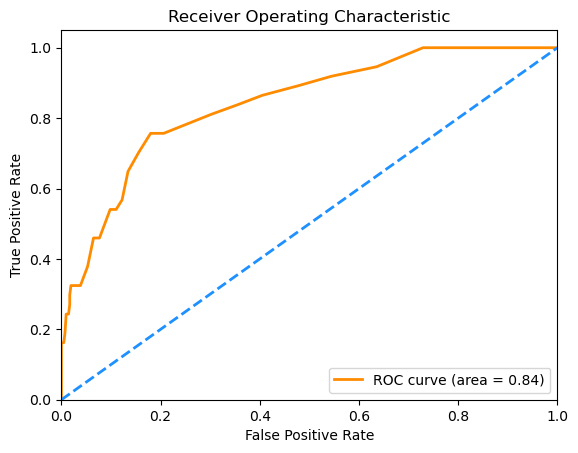

In [6]:
y_prob=rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds=roc_curve(y_test, y_prob)
roc_auc=auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='dodgerblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

We can still see the model has some predictive power, probably generated by the many correct samples it guesses within the majority class.

### Logistic regression

In [7]:
logistic_model=LogisticRegression(class_weight='balanced', random_state=564)
logistic_model.fit(X_train, y_train)
y_pred=logistic_model.predict(X_test)
mcc=matthews_corrcoef(y_test, y_pred)

print(f"MCC: {mcc}")
report=classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

MCC: 0.16464439707531803
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.78       417
           1       0.14      0.62      0.23        37

    accuracy                           0.66       454
   macro avg       0.55      0.64      0.51       454
weighted avg       0.89      0.66      0.74       454



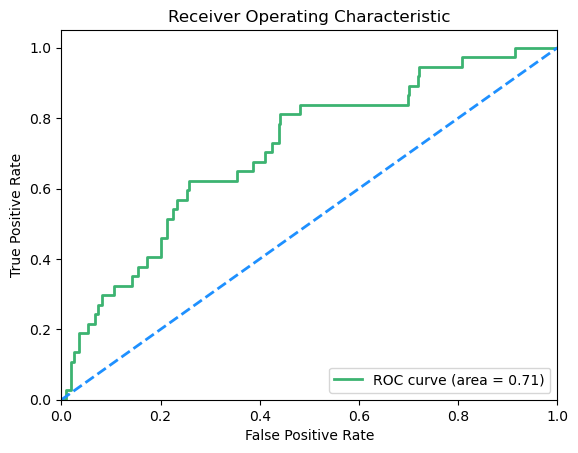

In [8]:
y_prob=logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds=roc_curve(y_test, y_prob)
roc_auc=auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='mediumseagreen', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='dodgerblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

As before, results are not great, although they look a little bit more promising. We can now proceed with MLP:

### Multi Layer Perceptron

In [9]:
mlp_model=MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=564, activation='tanh', solver='adam')
mlp_model.fit(X_train, y_train)
y_pred=mlp_model.predict(X_test)
mcc=matthews_corrcoef(y_test, y_pred)

print(f"MCC: {mcc}")
report=classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

MCC: 0.09340562391364761
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       417
           1       0.29      0.05      0.09        37

    accuracy                           0.91       454
   macro avg       0.60      0.52      0.52       454
weighted avg       0.87      0.91      0.88       454



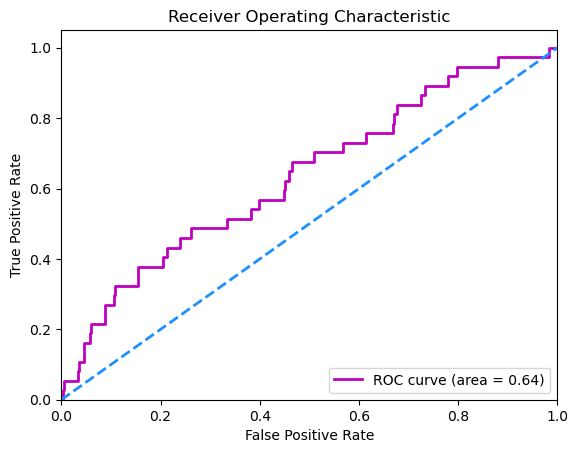

In [10]:
y_prob=mlp_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds=roc_curve(y_test, y_prob)
roc_auc=auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='m', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='dodgerblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

This time it looks like the model had very low predictive power in respect to the others (in terms of AUC) but had a bit higher values of precision and recall than Random Forest.
We can also try some cross validation for each model to check whether things improve, stay the same or worsen; this will give us more validity and more idea of how the model is behaving in general:

### Cross Validation of models

In [11]:
warnings.filterwarnings('ignore')
mcc_scorer=make_scorer(matthews_corrcoef)
cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
rf_scores=cross_val_score(rf_model, X_train, y_train, cv=cv, scoring=mcc_scorer)
print(f"Random Forest Mean MCC: {rf_scores.mean()}")
logistic_scores=cross_val_score(logistic_model, X_train, y_train, cv=cv, scoring=mcc_scorer)
print(f"Logistic Regression Mean MCC: {logistic_scores.mean()}")
mlp_scores=cross_val_score(mlp_model, X_train, y_train, cv=cv, scoring=mcc_scorer)
print(f"MLP Mean MCC: {mlp_scores.mean()}")

Random Forest Mean MCC: 0.022554905985727115
Logistic Regression Mean MCC: 0.178819521013816
MLP Mean MCC: 0.08366131741180308


We can see that some things have changed: it looks like on average Logistic regression is the best one while Random Forest is the worst one. MLP is considerably lower than Logistic regression. 
At this point the main problems we have are still imbalances across the dataset, and the simplest thing to do to combat them is try and balance class weights for random forest and logistic regression.

## Class weights

We can define first class weights as follows:

In [12]:
class_weights=compute_class_weight(class_weight={1:12}, classes=np.array([0, 1]), y=y_train) # 1 to 12 is the same proportion of the class imbalance
class_weights_dict={0: class_weights[0], 1: class_weights[1]}

Now we initiate and train the models, and skip already to the cross validation to check the best one:

In [13]:
rf_model=RandomForestClassifier(class_weight=class_weights_dict, random_state=564)
rf_model.fit(X_train, y_train)

logistic_model=LogisticRegression(class_weight=class_weights_dict, random_state=564)
logistic_model.fit(X_train, y_train)

mcc_scorer=make_scorer(matthews_corrcoef)
cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
rf_scores=cross_val_score(rf_model, X_train, y_train, cv=cv, scoring=mcc_scorer)
print(f"Random Forest Mean MCC: {rf_scores.mean()}")
logistic_scores=cross_val_score(logistic_model, X_train, y_train, cv=cv, scoring=mcc_scorer)
print(f"Logistic Regression Mean MCC: {logistic_scores.mean()}")

y_prob=rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds=roc_curve(y_test, y_prob)
roc_auc=auc(fpr, tpr)

print(f'AUC for rf: {roc_auc:.2f}')

y_prob=logistic_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds=roc_curve(y_test, y_prob)
roc_auc=auc(fpr, tpr)

print(f'AUC for logistic: {roc_auc:.2f}')

Random Forest Mean MCC: 0.09789453055635185
Logistic Regression Mean MCC: 0.1659540921612403
AUC for rf: 0.83
AUC for logistic: 0.71


Note that loss of predicting power is mostly none, as shown in the AUC. We don't see many changes, so we can move on to more drastic changes such as undersampling. 

## Undersampling, no class weights

The idea is to undersample the majority class to solve imbalance problems, while hoping the loss of predictive power is not too high: let's try that.

In [14]:
undersampler=RandomUnderSampler(random_state=564)
X_train_under, y_train_under=undersampler.fit_resample(X_train, y_train)

As before we can skip directly to the cross validated scores:

In [15]:
rf_model=RandomForestClassifier(class_weight='balanced', random_state=564)
rf_model.fit(X_train_under, y_train_under)

logistic_model=LogisticRegression(class_weight='balanced', random_state=564)
logistic_model.fit(X_train_under, y_train_under)

mlp_model=MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=564, activation='tanh', solver='adam')
mlp_model.fit(X_train_under, y_train_under)

mcc_scorer=make_scorer(matthews_corrcoef)
cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
rf_scores=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
print(f"Random Forest Mean MCC: {rf_scores.mean()}")
logistic_scores=cross_val_score(logistic_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
print(f"Logistic Regression Mean MCC: {logistic_scores.mean()}")
mlp_scores=cross_val_score(mlp_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
print(f"MLP Mean MCC: {mlp_scores.mean()}")

Random Forest Mean MCC: 0.4075514754860978
Logistic Regression Mean MCC: 0.298687377218658
MLP Mean MCC: 0.20046202593873788


To also check for an average across seeds of undersampling and generalise relationships highlighted by models within the dataset, we can average over seeds of RandomUnderSampler:

In [16]:
means_rf, means_log, means_mlp=[], [], []
randoms=[random.randint(0, 999) for _ in range(50)]
for number in randoms:
    undersampler=RandomUnderSampler(random_state=number)
    X_train_under, y_train_under=undersampler.fit_resample(X_train, y_train)
    rf_model=RandomForestClassifier(class_weight='balanced', random_state=564)
    rf_model.fit(X_train_under, y_train_under)

    logistic_model=LogisticRegression(class_weight='balanced', random_state=564)
    logistic_model.fit(X_train_under, y_train_under)

    mlp_model=MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=564, activation='tanh', solver='adam')
    mlp_model.fit(X_train_under, y_train_under)

    mcc_scorer=make_scorer(matthews_corrcoef)
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
    rf_score=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
    means_rf.append(np.mean(rf_scores))
    logistic_scores=cross_val_score(logistic_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
    means_log.append(np.mean(logistic_scores))
    mlp_scores=cross_val_score(mlp_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
    means_mlp.append(np.mean(mlp_scores))
print('MCC rf mean of means: ', np.mean(means_rf))
print('MCC log mean of means: ', np.mean(means_log))
print('MCC mlp mean of means: ', np.mean(means_mlp))

MCC rf mean of means:  0.4075514754860978
MCC log mean of means:  0.2742685104187023
MCC mlp mean of means:  0.25528310606146376


This time it looks like the undersampling improved substantially our MCC scores, proving that the main problem was the imbalance of the dataset. We can now try and see how much predictive power we lost and how the three compare through a ROC curve plot:

AUC for rf: 0.81
AUC for logistic: 0.61
AUC for MLP: 0.66


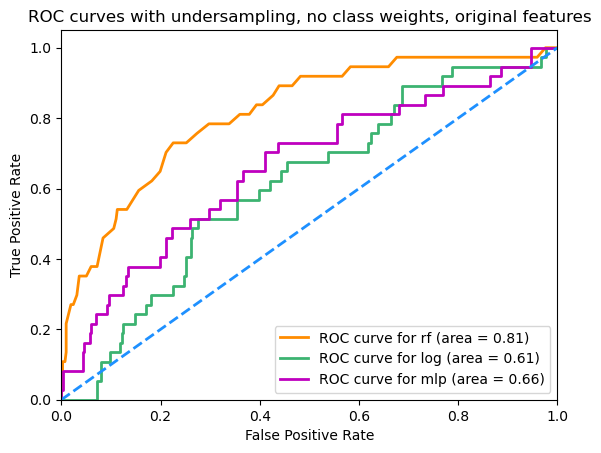

In [17]:
y_prob=rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds=roc_curve(y_test, y_prob)
roc_auc_rf=auc(fpr_rf, tpr_rf)

print(f'AUC for rf: {roc_auc_rf:.2f}')

y_prob=logistic_model.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, thresholds=roc_curve(y_test, y_prob)
roc_auc_log=auc(fpr_log, tpr_log)

print(f'AUC for logistic: {roc_auc_log:.2f}')

y_prob=mlp_model.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, thresholds=roc_curve(y_test, y_prob)
roc_auc_mlp=auc(fpr_mlp, tpr_mlp)

print(f'AUC for MLP: {roc_auc_mlp:.2f}')

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve for rf (area = {roc_auc_rf:.2f})')
plt.plot(fpr_log, tpr_log, color='mediumseagreen', lw=2, label=f'ROC curve for log (area = {roc_auc_log:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='m', lw=2, label=f'ROC curve for mlp (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='dodgerblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves with undersampling, no class weights, original features')
plt.legend(loc="lower right")
plt.savefig('ROC_undersampling_noweights.png',dpi=300,  bbox_inches='tight')
plt.show()

We can see that we almost lost no predictive power for all three curves. To further improve RF and Logistic regression we can try and combine class weighthing and undersampling:

## Undersampling, class weights

We redefine class weights:

In [18]:
class_weights=compute_class_weight(class_weight={1:12}, classes=np.array([0, 1]), y=y_train) # 1 to 12 is the same proportion of the class imbalance
class_weights_dict={0: class_weights[0], 1: class_weights[1]}

And we also undersample:

In [19]:
undersampler=RandomUnderSampler(random_state=564)
X_train_under, y_train_under=undersampler.fit_resample(X_train, y_train)

In [20]:
rf_model=RandomForestClassifier(class_weight=class_weights_dict, random_state=564)
rf_model.fit(X_train_under, y_train_under)

logistic_model=LogisticRegression(class_weight=class_weights_dict, random_state=564)
logistic_model.fit(X_train_under, y_train_under)

mlp_model=MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=564, activation='tanh', solver='adam')
mlp_model.fit(X_train_under, y_train_under)

mcc_scorer=make_scorer(matthews_corrcoef)
cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
rf_scores=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
print(f"Random Forest Mean MCC: {rf_scores.mean()}")
logistic_scores=cross_val_score(logistic_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
print(f"Logistic Regression Mean MCC: {logistic_scores.mean()}")
mlp_scores=cross_val_score(mlp_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
print(f"MLP Mean MCC: {mlp_scores.mean()}")


Random Forest Mean MCC: 0.35053824318278604
Logistic Regression Mean MCC: 0.06362954794702183
MLP Mean MCC: 0.20046202593873788


To also check for an average across seeds of undersampling and generalise relationships highlighted by models within the dataset, we can average over seeds of RandomUnderSampler:

In [21]:
means_rf, means_log, means_mlp=[], [], []
randoms=[random.randint(0, 999) for _ in range(50)]
for number in randoms:
    undersampler=RandomUnderSampler(random_state=number)
    X_train_under, y_train_under=undersampler.fit_resample(X_train, y_train)
    rf_model=RandomForestClassifier(class_weight=class_weights_dict, random_state=564)
    rf_model.fit(X_train_under, y_train_under)

    logistic_model=LogisticRegression(class_weight=class_weights_dict, random_state=564)
    logistic_model.fit(X_train_under, y_train_under)

    mlp_model=MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=564, activation='tanh', solver='adam')
    mlp_model.fit(X_train_under, y_train_under)

    mcc_scorer=make_scorer(matthews_corrcoef)
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
    rf_score=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
    means_rf.append(np.mean(rf_scores))
    logistic_scores=cross_val_score(logistic_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
    means_log.append(np.mean(logistic_scores))
    mlp_scores=cross_val_score(mlp_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
    means_mlp.append(np.mean(mlp_scores))
print('MCC rf mean of means: ', np.mean(means_rf))
print('MCC log mean of means: ', np.mean(means_log))
print('MCC mlp mean of means: ', np.mean(means_mlp))

MCC rf mean of means:  0.3505382431827861
MCC log mean of means:  0.1401485346029349
MCC mlp mean of means:  0.2591372415153524


This time it looks like class weighting actually proved not useful and worsened our MCC scores. Logistic regression was especially undermined by the class weighting while MLP improved and RF kept somewhat similar values. At last let's also try to check their AUC:

AUC for rf: 0.79
AUC for logistic: 0.68
AUC for MLP: 0.63


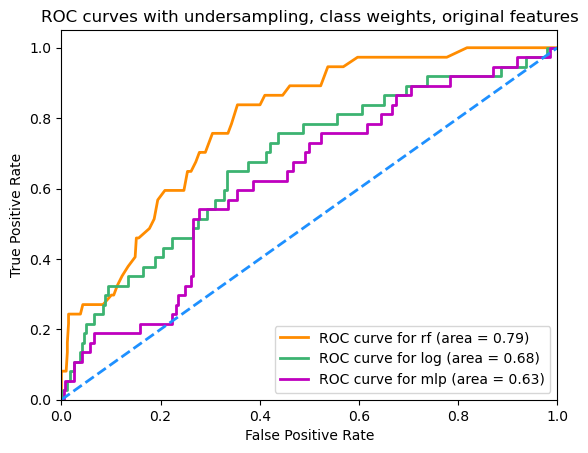

In [22]:
y_prob=rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds=roc_curve(y_test, y_prob)
roc_auc_rf=auc(fpr_rf, tpr_rf)

print(f'AUC for rf: {roc_auc_rf:.2f}')

y_prob=logistic_model.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, thresholds=roc_curve(y_test, y_prob)
roc_auc_log=auc(fpr_log, tpr_log)

print(f'AUC for logistic: {roc_auc_log:.2f}')

y_prob=mlp_model.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, thresholds=roc_curve(y_test, y_prob)
roc_auc_mlp=auc(fpr_mlp, tpr_mlp)

print(f'AUC for MLP: {roc_auc_mlp:.2f}')

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve for rf (area = {roc_auc_rf:.2f})')
plt.plot(fpr_log, tpr_log, color='mediumseagreen', lw=2, label=f'ROC curve for log (area = {roc_auc_log:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='m', lw=2, label=f'ROC curve for mlp (area = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='dodgerblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves with undersampling, class weights, original features')
plt.legend(loc="lower right")
plt.savefig('ROC_under_weights.png', dpi=300,  bbox_inches='tight')
plt.show()

Here too the AUC decreased, signifying a loss in predictive power. We can safely say the best option is to just undersample the dataset and use a Random Forest classifier, which has the highest explainability, MCC and AUC.

## Model explainability test: feature engineering impact

Within the data aggregation notebook, we tried summing up different questions in some subcategories for easier interpretation. Let's now try to check for a Random Forest model with no class weights, cross validated 10 times and averaged 50 times over different seeds for undersampling, if we have a significant loss in predictive power and/or MCC. That would indicate that this technique is infeasible because of the loss of predictive power and/or its impact in predicting the minority class correctly.

We read the new dataset from the aggregated file:

In [23]:
df=pd.read_csv('aggr_data.csv')
X=df[['qd1', 'AREA5', 'qd7', 'qd9', 'qd10', 'fin_knowledge_score', 'Debtor', 'Perc_Fin_Lit', 'Saver_Spender','Planner_Easygoer', 'Fin_Products_Experience', 'Fin_Indipendence', 'Approach_Digitalised']]
y=df['defrauded']

In [24]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=564, stratify=y) # 80-20 train test split, stratified to combat class imbalances

In [25]:
undersampler=RandomUnderSampler(random_state=564)
X_train_under, y_train_under=undersampler.fit_resample(X_train, y_train)

In [28]:
means_rf=[]
auc_scores=[]
randoms=[random.randint(0, 999) for _ in range(50)]
for number in randoms:
    undersampler=RandomUnderSampler(random_state=number)
    X_train_under, y_train_under=undersampler.fit_resample(X_train, y_train)
    rf_model=RandomForestClassifier(class_weight='balanced', random_state=564)
    rf_model.fit(X_train_under, y_train_under)

    mcc_scorer=make_scorer(matthews_corrcoef)
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
    rf_score=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=mcc_scorer)
    means_rf.append(np.mean(rf_score))
    y_pred_proba=cross_val_predict(rf_model, X_train_under, y_train_under, cv=cv, method="predict_proba")[:, 1]
    auc_simple=roc_auc_score(y_train_under, y_pred_proba)
    auc_scores.append(auc_simple)
print('MCC rf mean of means: ', np.mean(means_rf))
print('AUC rf mean: ', np.mean(auc_scores))

MCC rf mean of means:  0.35060225675231066
AUC rf mean:  0.7327368136570425


AUC for rf: 0.76


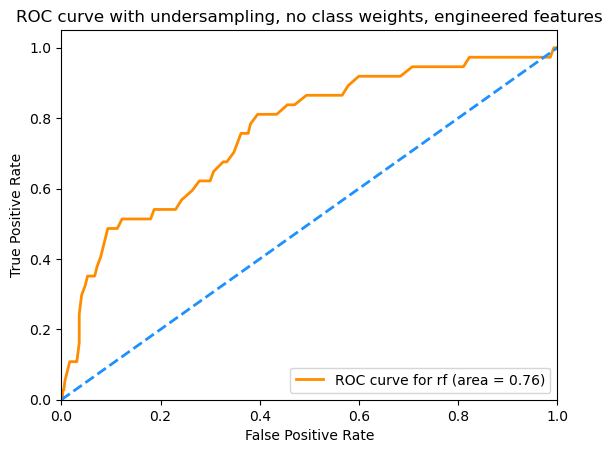

In [29]:
y_prob=rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds=roc_curve(y_test, y_prob)
roc_auc_rf=auc(fpr_rf, tpr_rf)

print(f'AUC for rf: {roc_auc_rf:.2f}')


plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve for rf (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='dodgerblue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve with undersampling, no class weights, engineered features')
plt.legend(loc="lower right")
plt.savefig('ROC_aggr_rf_under_noweights.png', dpi=300,  bbox_inches='tight')
plt.show()

We see we have a small loss in predictive power given the AUC for the ROC curve is less but we also see that our MCC even improved slightly - indicating a good result for our feature engineering.

In [30]:
means_rf_recall, means_rf_precision , means_rf_f1=[],[], [] 

randoms = [random.randint(0, 999) for _ in range(50)]
for number in randoms:
    undersampler=RandomUnderSampler(random_state=number)
    X_train_under, y_train_under=undersampler.fit_resample(X_train, y_train)
    
    rf_model=RandomForestClassifier(class_weight='balanced', random_state=564)
    rf_model.fit(X_train_under, y_train_under)
    
    f1_scorer=make_scorer(f1_score, average='binary')
    precision_scorer=make_scorer(precision_score, average='binary')
    recall_scorer=make_scorer(recall_score, average='binary')
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=564)
    
    rf_scores_f1=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=f1_scorer)
    rf_scores_precision=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=precision_scorer)
    rf_scores_recall=cross_val_score(rf_model, X_train_under, y_train_under, cv=cv, scoring=recall_scorer)
    
    means_rf_f1.append(np.mean(rf_scores_f1))
    means_rf_precision.append(np.mean(rf_scores_precision))
    means_rf_recall.append(np.mean(rf_scores_recall))

print('F1 rf mean of means: ', np.mean(means_rf_f1))
print('Precision rf mean of means: ', np.mean(means_rf_precision))
print('Recall rf mean of means: ', np.mean(means_rf_recall))

F1 rf mean of means:  0.6569725161821155
Precision rf mean of means:  0.6789638526375437
Recall rf mean of means:  0.6502190476190477
